In [1]:
#Import all the required libraries
import time
import re
import pandas as pd
import numpy as np
from skimage import io
import random
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,Model
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu
import socket
import pickle5 as pickle
from tensorflow.keras.activations import tanh
from tensorflow.keras.activations import softmax
import matplotlib.pyplot as plt
import tensorboard

In [2]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [3]:
!rm -rf ./logs/

In [4]:
in_nimble = False
in_WSL = False
in_tpu = False
in_pi = False

host = socket.gethostname()
if('cuda' in host):
    in_nimble = True
    print("In NimbleBox")
if(host == 'LTsuphale-NC2JM'):
    in_WSL = True
    print("In WSL")
if(host == 'raspberrypi'):
    in_pi = True
    print("In raspberry-pi")

In WSL


In [5]:
total_test_images = 128

if(in_WSL == True):
    images_path='/home/suphale/snehal_bucket/coco/raw-data/train2017/'
    images_path='/home/suphale/WorkSpace/test_images'
if(in_nimble == True):
    images_path='/mnt/disks/user/project/coco/train2017/'
if(in_pi == True):
    images_path='/home/pi/WorkSpace/test_images/'

text_file = './lists/captions_' + str(total_test_images) + '.txt'
list_file = './lists/images_' + str(total_test_images) + '.txt'

In [6]:
max_tokenized_words = 10000
MAX_SEQ_LENGTH = 25
batch_size = 32
embedding_dim = 256 
units = 512

In [7]:
with open('saved_model/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)


In [8]:
def read_image(image_path,label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (299, 299))
    image = tf.cast(image, tf.float32)
    image /= 127.5
    image -= 1.
    return image, label

In [9]:
with open('saved_model/image_features_extract_model.json', 'r') as json_file:
    json_savedModel= json_file.read()
image_features_extract_model = tf.keras.models.model_from_json(json_savedModel)
image_features_extract_model.load_weights('saved_model/image_features_extract_model.h5')

In [10]:
def extract_image_features(sample_img_batch):
    features = image_features_extract_model(sample_img_batch)
    features = tf.reshape(features, [sample_img_batch.shape[0],8*8, 2048])
    return features

In [11]:
vocab_size = max_tokenized_words + 1

In [12]:
# ### Encoder
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        # build your Dense layer with relu activation
        self.dense = tf.keras.layers.Dense(embed_dim, activation='relu')
        
    def call(self, features):
        # extract the features from the image shape: (batch, 8*8, embed_dim)
        features = self.dense(features)
        return features    

In [13]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.units=units
        # build your Dense layer
        self.W1 = tf.keras.layers.Dense(units)
        # build your Dense layer
        self.W2 = tf.keras.layers.Dense(units)
        # build your final Dense layer with unit 1
        # self.V = tf.keras.layers.Dense(1, activation='softmax')
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        
        # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        # build your score funciton to shape: (batch_size, 8*8, units)
        score = tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        # extract your attention weights with shape: (batch_size, 8*8, 1)
        score = self.V(score)
        attention_weights = softmax(score, axis=1)

        # shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = attention_weights * features
        # reduce the shape to (batch_size, embedding_dim)
        # context_vector = tf.reduce_sum(context_vector, axis=1)
        context_vector = tf.reduce_mean(context_vector, axis=1)

        return context_vector, attention_weights   

In [14]:
# ### Decoder
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units = units
        # iniitalise your Attention model with units
        self.attention = Attention_model(self.units)
        # build your Embedding layer
        self.embed = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        # build your Dense layer
        self.d1 = tf.keras.layers.Dense(self.units)
        # build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size)


    def call(self,x,features, hidden):
        #create your context vector & attention weights from attention model
        context_vector, attention_weights = self.attention(features, hidden)
        # embed your input to shape: (batch_size, 1, embedding_dim)
        embed = self.embed(x)
        # Concatenate your input with the context vector from attention layer. 
        # Shape: (batch_size, 1, embedding_dim + embedding_dim)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)
        # Extract the output & hidden state from GRU layer. 
        # Output shape : (batch_size, max_length, hidden_size)
        output, state = self.gru(embed)
        output = self.d1(output)
        # shape : (batch_size * max_length, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2])) 
        # shape : (batch_size * max_length, vocab_size)
        output = self.d2(output)

        return output, state, attention_weights

    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))


In [15]:
s = tf.zeros([32, 64, 2048], tf.int32)

encoder=Encoder(embedding_dim)

decoder=Decoder(embedding_dim, units, vocab_size)

features=encoder(s)

hidden = decoder.init_state(batch_size=batch_size)
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * batch_size, 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)

In [16]:
decoder.load_weights("saved_model/decoder.h5")
encoder.load_weights("saved_model/encoder.h5")

In [17]:
#%tensorboard --logdir logs

In [18]:
def evaluate(image):
    attention_features_shape = 64
    attention_plot = np.zeros((MAX_SEQ_LENGTH, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    # process the input image to desired format before extracting features
    temp_input = tf.expand_dims(read_image(image,[])[0], 0) 
    # Extract features using our feature extraction model
    img_tensor_val = extract_image_features(temp_input)
    # img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    # extract the features by passing the input to encoder
    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(MAX_SEQ_LENGTH):
        # get the output from decoder
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        #extract the predicted id(embedded value) which carries the max value
        predicted_id = tf.argmax(tf.transpose(predictions))
        predicted_id = predicted_id.numpy()[0]
        # map the id to the word from tokenizer and append the value to the result list
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions

In [19]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [20]:
import time

all_imgs = [images_path + line.rstrip() for line in open(list_file)]
all_imgs = sorted(all_imgs)
total_num_images = len(all_imgs)
print("The total images present in the dataset: {}".format(total_num_images))

#Visualise both the images & text present in the dataset
print("The total images present in the dataset: {}".format(total_num_images))
num_lines = sum(1 for line in open(text_file))
print("The total number of lines in the caption file: {}".format(num_lines))

The total images present in the dataset: 128
The total images present in the dataset: 128
The total number of lines in the caption file: 641


In [21]:
# define a function to clean text data
def extract_jpg_caption(line):
    char_filter = r"[^\w]"

    jpg_path = None
    caption = None

    jpg_position = line.find(".jpg")
    if(jpg_position != -1):
        jpg_path = images_path + '/' + line[:jpg_position+4]

        caption = line[jpg_position+5:].strip()

        # convert words to lower case
        caption = caption.lower()

        # split into words
        words = caption.split()

        # strip whitespace from all words
        words = [word.strip() for word in words]

        # join back words to get document
        caption = " ".join(words)

        # remove unwanted characters
        caption = re.sub(char_filter, " ", caption)

        # remove unwanted characters
        caption = re.sub(r"\.", " ", caption)

        # replace multiple whitespaces with single whitespace
        caption = re.sub(r"\s+", " ", caption)

        # strip whitespace from document
        caption = caption.strip()

        caption = '<start> ' + caption + ' <end>'

    return jpg_path, caption



In [32]:
#store all the image id here
all_img_id= [] 
#store all the image path here
all_img_vector=[]
#store all the captions here
annotations_dict = {} 
annotations= [] 
# list of all captions in word list format
annotations_word_list = []

In [33]:
def load_doc(filename):
    #your code here
    file  = open(filename, 'r') 
    Lines = file.readlines() 
    
    text = ""
    count = 0
    for line in Lines:
        jpg_path, caption = extract_jpg_caption(line)
        if(jpg_path != None):
            all_img_id.append(count)
            all_img_vector.append(jpg_path)
            annotations.append(caption)

            caption_list = []
            if jpg_path in annotations_dict.keys():
                caption_list = annotations_dict[jpg_path]
            caption_list.append(caption)
            annotations_dict[jpg_path] = caption_list

            word_list = caption.split()
            annotations_word_list.append(word_list)
            text += " " + caption
            count += 1
    file.close()
    return text

doc = load_doc(text_file)


In [77]:
random_num = 0
img_path = all_img_vector[random_num]
#print("----------------")
#print(img_path)
#print(annotations[random_num])
print("")
image = io.imread(img_path)
# plt.imshow(image)
# print(img_path)
# print(annotations[random_num])
# print(annotations[random_num+1])
# print(annotations_dict[img_path])
# print(annotations[random_num])

test_image = img_path
real_caption = annotations[random_num]

t0= time.perf_counter()
result, attention_plot,pred_test = evaluate(test_image)
t1 = time.perf_counter() - t0

pred_caption=' '.join(result).rsplit(' ', 1)[0]
real_appn = []
real_caption_list = annotations_dict[img_path]
for real_caption in real_caption_list:
    real_caption=filt_text(real_caption)
    real_appn.append(real_caption.split())

reference = real_appn
candidate = pred_caption.split()

# print(reference)
# print(candidate)

score = sentence_bleu(reference, candidate,weights=(1, 0, 0, 0)) #set your weights)

print("Time: %.2f BLEU: %.2f" % (t1,score))
print ('Real:', real_caption)
print ('Pred:', pred_caption)



Time: 1.29 BLEU: 0.25
Real: an image of a living room setting with furniture
Pred: a room with a living room with a living room with a living room with a living room with a living room with a



Time: 0.45 BLEU: 0.22
Real: a painting with a person in a gasmask
Pred: a bunch of different patterns being forcefully held up

Time: 0.51 BLEU: 0.64
Real: a crowd of people are standing in line
Pred: a group of people are standing around a crowd of people

Time: 0.41 BLEU: 0.50
Real: two women carrying their luggage through a parking lot
Pred: a woman is walking with a car

Time: 0.44 BLEU: 0.74
Real: a large ship is on the water near docked small boats
Pred: a boat is docked at the water

Time: 0.44 BLEU: 0.22
Real: a painting with a person in a gasmask
Pred: a bunch of different patterns being forcefully held up

Time: 0.43 BLEU: 0.44
Real: armavia air plane on tar mack with other planes in the distance
Pred: a large jetliner sitting on top of a runway

Time: 0.37 BLEU: 0.48
Real: two snow skiers one in a red jacket and trees
Pred: a man is on a skateboard

Time: 0.43 BLEU: 0.44
Real: armavia air plane on tar mack with other planes in the distance
Pred: a large jetliner sitting on 

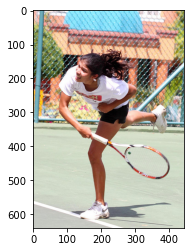

In [79]:
total_time = 0.0
max_test_images = total_test_images
for i in range(max_test_images):
    random_num = random.randint(0,total_num_images-1)
    img_path = all_img_vector[random_num]
    #print("----------------")
    #print(img_path)
    #print(annotations[random_num])
    print("")
    # image = io.imread(img_path)
    # plt.imshow(image)

    test_image = img_path
    real_caption = annotations[random_num]

    t0= time.perf_counter()
    result, attention_plot,pred_test = evaluate(test_image)
    t1 = time.perf_counter() - t0
    total_time = total_time + t1

    real_caption=filt_text(real_caption)      
    pred_caption=' '.join(result).rsplit(' ', 1)[0]
    # real_appn = []
    # real_appn.append(real_caption.split())
    # reference = real_appn
    # candidate = pred_caption.split()

    real_appn = []
    real_caption_list = annotations_dict[img_path]
    for real_caption in real_caption_list:
        real_caption=filt_text(real_caption)
        real_appn.append(real_caption.split())
    reference = real_appn
    candidate = pred_caption.split()

    score = sentence_bleu(reference, candidate, weights=[1]) #set your weights)

    print("Time: %.2f BLEU: %.2f" % (t1,score))
    print ('Real:', real_caption)
    print ('Pred:', pred_caption)

print("Average time = %f" % (total_time/max_test_images))

In [22]:
#dot_img_file = './image_features_extract_model.png'
#tf.keras.utils.plot_model(image_features_extract_model, to_file=dot_img_file, show_shapes=True)

In [23]:
#dot_img_file = './encoder.png'
#tf.keras.utils.plot_model(encoder, to_file=dot_img_file, show_shapes=True)